# Lecture des données 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

telechargement des données 

In [2]:
import requests, zipfile, io
zip_file_url = 'https://moncoachdata.com/wp-content/uploads/cell_images.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [3]:
data_dir = 'cell_images'

liste les differents directory dans ' cel_images

In [4]:
os.listdir(data_dir)

['test', 'train']

creation d'un path pour le directory train et test

In [5]:
test_path = data_dir+'/test/'
train_path = data_dir+'/train/'

Dans chaque directory test et train il y a deux directory 

In [6]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path)

['parasitized', 'uninfected']

On affiche le nom de la premiere image dans cell_images/train/parasitized

In [85]:
os.listdir(train_path+'parasitized')[0]
os.listdir(test_path+'uninfected')[0]

'C178P139NThinF_IMG_20151201_154524_cell_40.png'

On stock tout le path de cette celle dans para_cell

In [9]:
para_cell = train_path+'parasitized'+'/C66P27N_ThinF_IMG_20150818_164754_cell_203.png'

In [86]:
para_cell2 = test_path+'uninfected'+'/C178P139NThinF_IMG_20151201_154524_cell_40.png'

On peut afficher cette cellule 

In [ ]:
imread(para_cell)

In [10]:
para_cell

'cell_images/train/parasitized/C66P27N_ThinF_IMG_20150818_164754_cell_203.png'

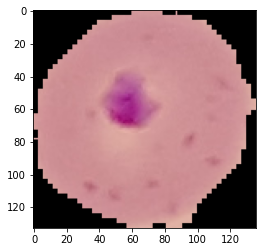

In [11]:
plt.imshow(imread(para_cell))

on refait cette manip pour une cellule saine 

In [12]:
os.listdir(train_path+'uninfected')[0]

'C205ThinF_IMG_20151106_151711_cell_172.png'

In [13]:
uninfected_cell = train_path+'uninfected'+'/C181P142ThinF_IMG_20151127_155914_cell_30.png'

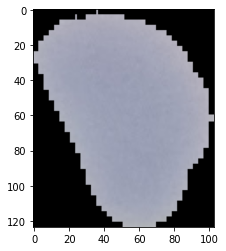

In [14]:
plt.imshow(imread(uninfected_cell))

On regarde le nombre d'images de cellules infectée et saine

il y a 12480 images de cellules parasitized dans train

il y a 12480 images de cellules uninfected dans train

il y a 1300 images de cellules parasitized dans test

il y a 1300 images de cellules uninfected dans test




In [15]:
len(os.listdir(test_path+'parasitized'))

1300

In [16]:
len(os.listdir(test_path+'uninfected'))

1300

On va lire toutes nos images une par une et stocker leur dimmensions dans deux tableau

In [17]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'uninfected'):
  img = imread(test_path+'uninfected'+'/'+image_filename)
  d1, d2, colors = img.shape
  dim1.append(d1)
  dim2.append(d2)

Les dimensions de chaque photos sont differentes, or notre modele ne peut accepter que des photos de meme dimmension , il va falloir normaliser la taille des photos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


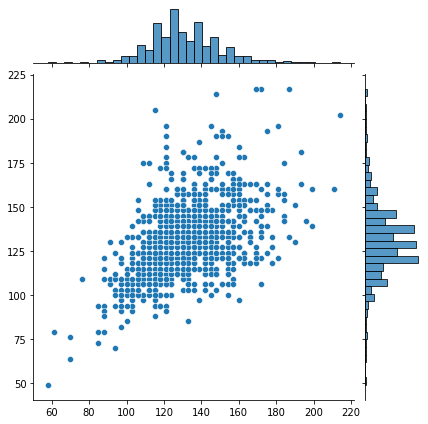

In [19]:
sns.jointplot(dim1, dim2)

On va calculer la valeur moyenne des tailles et on va reshape les images par cette moyenne, si certaines images sont plus grandes nous allons les rogner, sinon nous ajouterons des bordures

In [20]:
np.mean(dim1)

130.92538461538462

In [21]:
np.mean(dim2)

130.75

In [22]:
image_shape = (130,130,3)

# Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
help(ImageDataGenerator)

ImageDataGenerator permet de modifier aléatoirement des images 

In [25]:
image_gen = ImageDataGenerator(rotation_range=20, # faire pivoter l'image de 20 degres
                               width_shift_range = 0.1, #modifier largeur de la photo de 10% max
                               height_shift_range=0.1, # modifier la hauteur des photo
                               shear_range=0.1, #decoupe de l'image max 10%
                               zoom_range = 0.1,
                               horizontal_flip = True, 
                               fill_mode = 'constant', #remplir valeur manquante 
                               )

In [26]:
para_img = imread(para_cell)

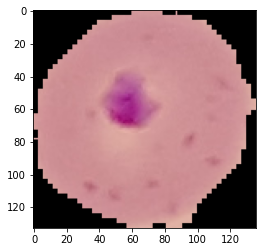

In [27]:
plt.imshow(para_img);

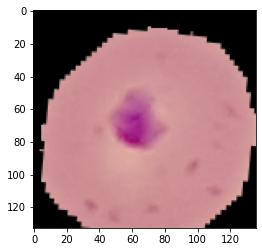

In [28]:
plt.imshow(image_gen.random_transform(para_img))

# Creation des batchs

In [29]:
os.listdir(train_path)

['parasitized', 'uninfected']

prend un path et genere des batch de data augmenté

In [30]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [31]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creation du modele

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [33]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape = (130,130,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape = (130,130,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape = (130,130,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
model.summary()

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [37]:
batch_size = 16

In [38]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2], #image_shape(130,130,3) on veut que 130,130
                                                color_mode = 'rgb',
                                                batch_size=batch_size,
                                                class_mode = 'binary')

Found 24958 images belonging to 2 classes.


In [39]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode = 'rgb',
                                                batch_size=batch_size,
                                                class_mode = 'binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [40]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
results = model.fit(train_image_gen, epochs = 20, validation_data=test_image_gen, callbacks=[early_stop])

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# evaluation du modele

In [52]:
from tensorflow.keras.models import load_model

In [53]:
model = load_model('malaria_detector.h5')

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [55]:
model.evaluate(test_image_gen)

163/163 [==============================] - 13s 79ms/step - loss: 0.1867 - accuracy: 0.9462


[0.18666142225265503, 0.9461538195610046]

In [56]:
model.metrics_names

['loss', 'accuracy']

on predit sur notre generator 

In [57]:
pred = model.predict(test_image_gen)

In [58]:
pred

array([[2.2184385e-03],
       [2.1111722e-04],
       [6.8427304e-05],
       ...,
       [9.1594648e-01],
       [9.2707896e-01],
       [9.6624440e-01]], dtype=float32)

on affiche true si la prediction est > 0.5 et false sinon

In [59]:
predictions = pred >0.5

In [60]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [61]:
len(pred)

2600

In [62]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1300
           1       0.93      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [63]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1211,   89],
       [  52, 1248]])

In [64]:
para_cell

'cell_images/train/parasitized/C66P27N_ThinF_IMG_20150818_164754_cell_203.png'

In [87]:
para_cell2

'cell_images/test/uninfected/C178P139NThinF_IMG_20151201_154524_cell_40.png'

# Faire une prediction

In [65]:
from tensorflow.keras.preprocessing import image

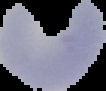

In [88]:
image.load_img(para_cell2)

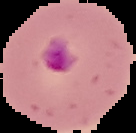

In [66]:
image.load_img(para_cell)

In [68]:
my_image = image.load_img(para_cell, target_size=image_shape)

In [89]:
my_image2 = image.load_img(para_cell2, target_size=image_shape)

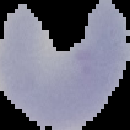

In [90]:
my_image2

In [91]:
my_img_arr = image.img_to_array(my_image2)

In [73]:
my_img_arr.shape

(130, 130, 3)

In [92]:
my_img_arr = np.expand_dims(my_image2, axis=0)

In [93]:
my_img_arr.shape

(1, 130, 130, 3)

In [94]:
(model.predict(my_img_arr) >0.5).astype('int32')

array([[1]], dtype=int32)

In [95]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}